In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import seaborn as sns

In [16]:
DATA_DIR = '/Users/rahulsajithpillai/Desktop/Electricity Market Modelling/Data analysis/9050csv_cleansed_data_set2_130a6915e7f8a17bb83efabdbdb7ec87'
SUMMER_MONTHS = {4,5,6,7,8,9,10}
WINTER_MONTHS = {11,12,1,2,3}
K_RANGE = range(2, 10)  # search range for k
ANNOTATE_PCA = False     # set True if you want points annotated (can clutter)
RANDOM_STATE = 42

In [17]:
def resample_to_hourly(df, filename):
    """Return hourly kWh series named 'actual' or None if required cols missing."""
    if 'Timestamp' not in df.columns:
        print(f"[WARN] No 'Timestamp' in {filename}")
        return None
    if 'Whole_System_Energy_Consumed' not in df.columns:
        print(f"[WARN] No 'Whole_System_Energy_Consumed' in {filename}")
        return None

    s = df.copy()
    s['Timestamp'] = pd.to_datetime(s['Timestamp'])
    s = s.set_index('Timestamp').sort_index()
    # Convert cumulative energy to interval energy
    s['actual'] = s['Whole_System_Energy_Consumed'].diff().fillna(0)
    hourly = s['actual'].resample('H').sum()
    return hourly.to_frame(name='actual')

In [18]:
def season_actual_24h(hourly_df, months_set):
    """
    Build a *raw* kWh 24h profile for a given season:
    - filter to season months
    - average kWh by hour across all season days (no normalization)
    Returns 1x24 DataFrame with columns Hour_00..Hour_23 or None if no data.
    """
    if hourly_df is None or hourly_df.empty:
        return None

    idx = pd.date_range(hourly_df.index.min(), hourly_df.index.max(), freq='H')
    h = hourly_df.reindex(idx, fill_value=0).copy()
    h['month'] = h.index.month
    h = h[h['month'].isin(months_set)]
    if h.empty:
        return None

    h['hour'] = h.index.hour
    prof = h.groupby('hour')['actual'].mean()  # kWh per hour, averaged across all season days
    prof = prof.reindex(range(24), fill_value=0.0)
    row = prof.to_frame().T
    row.columns = [f'Hour_{i:02d}' for i in range(24)]
    return row

In [19]:
def process_all_files_actual_by_season(data_dir, months_set):
    """Return DataFrame: one row per house, 24 hourly columns with *raw kWh* season-average."""
    profiles = []
    for filename in os.listdir(data_dir):
        if not filename.endswith('.csv'):
            continue
        try:
            df = pd.read_csv(os.path.join(data_dir, filename))
            hourly = resample_to_hourly(df, filename)
            if hourly is None:
                continue
            row = season_actual_24h(hourly, months_set)
            if row is None:
                continue
            row['House'] = filename
            profiles.append(row)
        except Exception as e:
            print(f"[WARN] Failed {filename}: {e}")

    if not profiles:
        return pd.DataFrame(columns=[f'Hour_{i:02d}' for i in range(24)] + ['House'])

    return pd.concat(profiles, ignore_index=True)

In [20]:
def daily_shape_average(hourly_df, months_set):
    """
    Build a 24h profile for a given season:
    1) normalize EACH DAY by its own daily total
    2) average normalized values by hour across all season days
    Returns 1x24 DataFrame with columns Hour_00..Hour_23 or None if no valid days.
    """
    if hourly_df is None or hourly_df.empty:
        return None

    # Fill gaps to avoid missing hours inside days
    idx = pd.date_range(hourly_df.index.min(), hourly_df.index.max(), freq='H')
    h = hourly_df.reindex(idx, fill_value=0).copy()
    h['month'] = h.index.month
    # Keep only target season months
    h = h[h['month'].isin(months_set)]
    if h.empty:
        return None

    h['date'] = h.index.date
    h['hour'] = h.index.hour

    # Compute per-day totals and avoid zero-total days
    day_totals = h.groupby('date')['actual'].transform('sum')
    valid = day_totals > 0
    if not valid.any():
        return None

    h = h[valid].copy()
    h['norm'] = h['actual'] / h.groupby('date')['actual'].transform('sum')

    # Mean shape per hour across all valid days in the season
    prof = h.groupby('hour')['norm'].mean()  # 0..23
    prof = prof.reindex(range(24), fill_value=0.0)
    row = prof.to_frame().T
    row.columns = [f'Hour_{i:02d}' for i in range(24)]
    return row

In [21]:
def process_all_files_by_season(data_dir, months_set):
    """Return DataFrame with one row per house, 24 hourly columns (normalized)."""
    profiles = []
    for filename in tqdm(os.listdir(data_dir), desc="Seasonal build"):
        if not filename.endswith('.csv'):
            continue
        try:
            df = pd.read_csv(os.path.join(data_dir, filename))
            hourly = resample_to_hourly(df, filename)
            if hourly is None:
                continue
            row = daily_shape_average(hourly, months_set)
            if row is None:
                continue
            row['House'] = filename
            profiles.append(row)
        except Exception as e:
            print(f"[WARN] Failed {filename}: {e}")

    if not profiles:
        return pd.DataFrame(columns=[f'Hour_{i:02d}' for i in range(24)] + ['House'])

    out = pd.concat(profiles, ignore_index=True)
    return out

In [22]:

def choose_k_and_cluster(X, k_range=K_RANGE, random_state=RANDOM_STATE, title_prefix=""):
    """Returns (labels, k_opt, model, inertias, silhouettes). Also plots elbow & silhouette."""
    inertias, silhouettes = [], []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=random_state)
        lab = km.fit_predict(X)
        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(X, lab))

    # Elbow
    plt.figure()
    plt.plot(list(k_range), inertias, marker='o')
    plt.title(f'{title_prefix}Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

    # Silhouette
    plt.figure()
    plt.plot(list(k_range), silhouettes, marker='s')
    plt.title(f'{title_prefix}Silhouette Scores')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

    # Pick k with max silhouette
    k_opt = list(k_range)[int(np.argmax(silhouettes))]
    model = KMeans(n_clusters=k_opt, random_state=random_state)
    labels = model.fit_predict(X)
    return labels, k_opt, model, inertias, silhouettes

In [23]:
def plot_pca(X, labels, title):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Z = pca.fit_transform(X)
    plt.figure(figsize=(9,7))
    for c in sorted(np.unique(labels)):
        pts = Z[np.array(labels) == c]
        plt.scatter(pts[:,0], pts[:,1], label=f'Cluster {c}')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [24]:
def plot_cluster_shapes(df_with_labels, title):
    """
    df_with_labels: columns Hour_00..Hour_23 + Cluster.
    Plots median shape per cluster with HH:00 x-axis.
    """
    hours = [f'Hour_{i:02d}' for i in range(24)]
    cluster_means = df_with_labels.groupby('Cluster')[hours].median()

    plt.figure(figsize=(12,6))
    for c in cluster_means.index:
        plt.plot(range(24), cluster_means.loc[c].values, label=f'Cluster {c}')
    plt.title(title)
    plt.xlabel('Hour of Day')
    plt.ylabel('Normalized Consumption')
    plt.xticks(ticks=range(24), labels=[f"{h:02d}:00" for h in range(24)], rotation=0)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
def finalize_and_export(season_name, base_df, labels, model):
    """
    Adds House ID (Property_ID), Cluster labels; saves profiles+labels, cluster sizes, centroids.
    Returns labeled dataframe.
    """
    df = base_df.copy()
    # Keep original filename or extract Property_ID if present
    df['House'] = df['House'].str.extract(r'Property_ID=(.*)\.csv').fillna(df['House'])
    df['Cluster'] = labels

    # Save profiles with labels
    out_profiles = f'{season_name}_clustered_profiles.csv'
    df.to_csv(out_profiles, index=False)
    print(f"[SAVE] {out_profiles}")

    # Cluster sizes
    counts = df['Cluster'].value_counts().sort_index()
    print(f"\n{season_name.capitalize()} — number of houses per cluster:")
    print(counts)
    counts.to_frame('Number_of_Houses').to_csv(f'{season_name}_cluster_sizes.csv')

    # Centroids (median shape per cluster and KMeans centers for reference)
    hours = [f'Hour_{i:02d}' for i in range(24)]
    medians = df.groupby('Cluster')[hours].median().sort_index()
    medians.to_csv(f'{season_name}_cluster_median_shapes.csv')
    km_centers = pd.DataFrame(model.cluster_centers_, columns=hours)
    km_centers.to_csv(f'{season_name}_kmeans_centroids.csv', index_label='Cluster')

    return df

Building SUMMER profiles (Apr–Oct) ...


Seasonal build:   1%|          | 9/742 [00:01<02:16,  5.36it/s]

[WARN] No 'Timestamp' in Property_ID=EOH1880.csv


Seasonal build:  21%|██        | 153/742 [00:30<01:16,  7.67it/s]

[WARN] No 'Timestamp' in Property_ID=EOH0345.csv


Seasonal build: 100%|██████████| 742/742 [02:28<00:00,  5.01it/s]


Summer valid houses: 733

Building WINTER profiles (Nov–Mar) ...


Seasonal build:   1%|          | 9/742 [00:01<02:08,  5.70it/s]

[WARN] No 'Timestamp' in Property_ID=EOH1880.csv


Seasonal build:  21%|██        | 153/742 [00:29<01:17,  7.64it/s]

[WARN] No 'Timestamp' in Property_ID=EOH0345.csv


Seasonal build: 100%|██████████| 742/742 [02:27<00:00,  5.04it/s]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Winter valid houses: 731


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

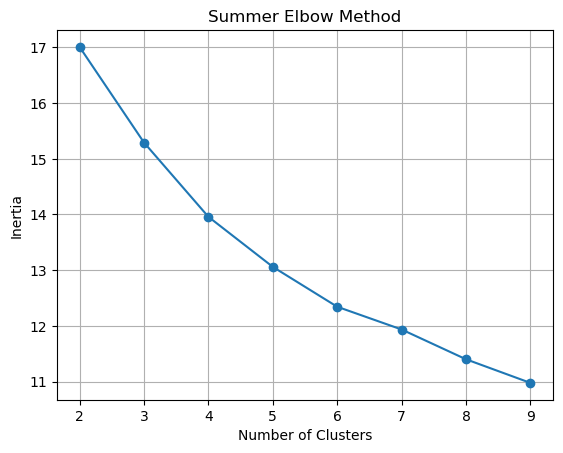

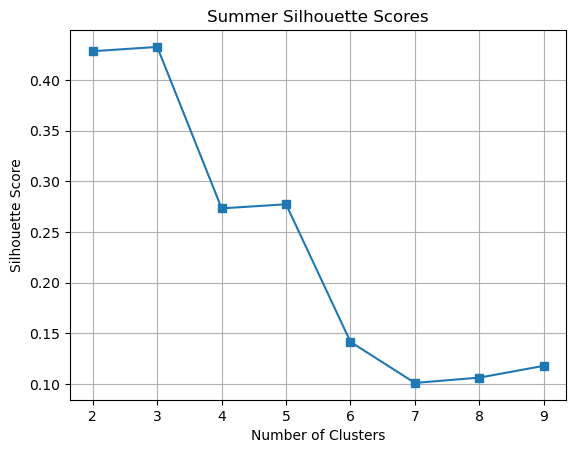

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Chosen k for Summer: 3


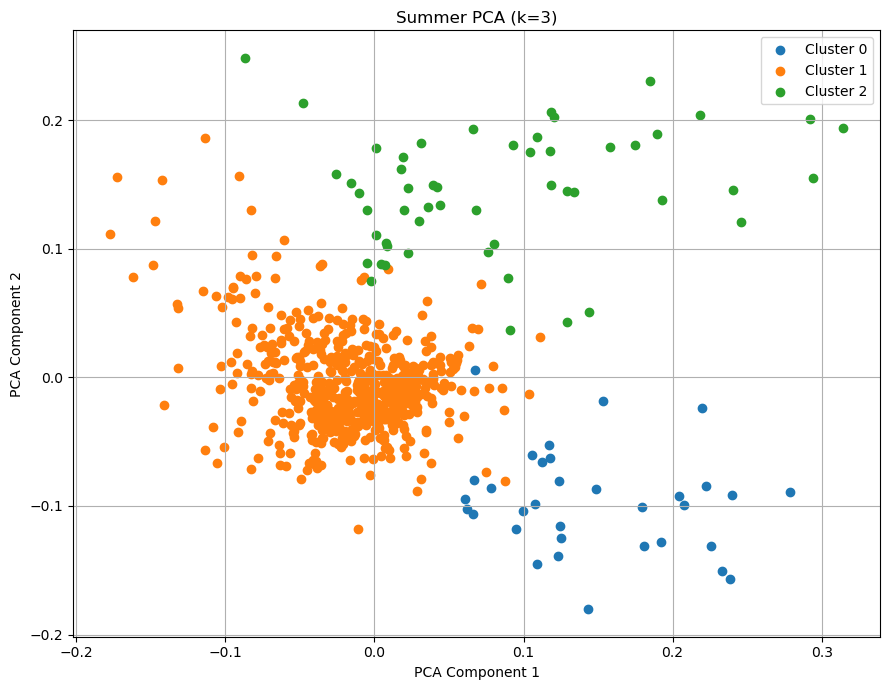

[SAVE] summer_clustered_profiles.csv

Summer — number of houses per cluster:
Cluster
0     33
1    647
2     53
Name: count, dtype: int64


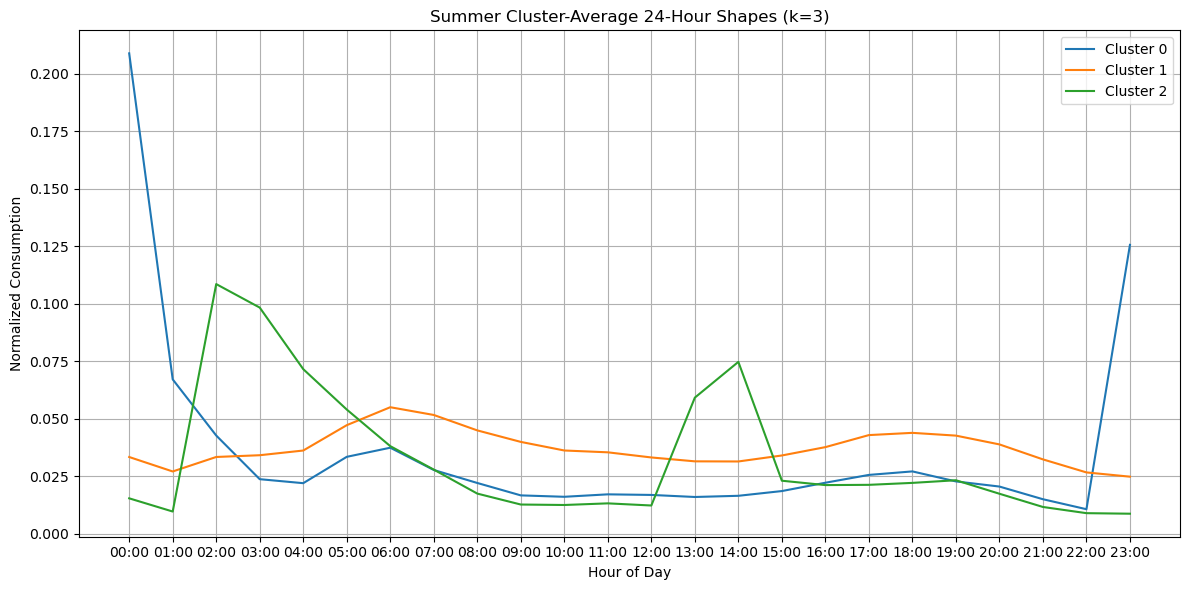

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

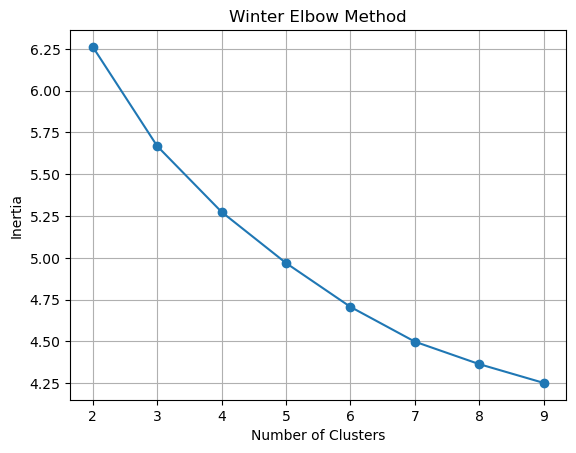

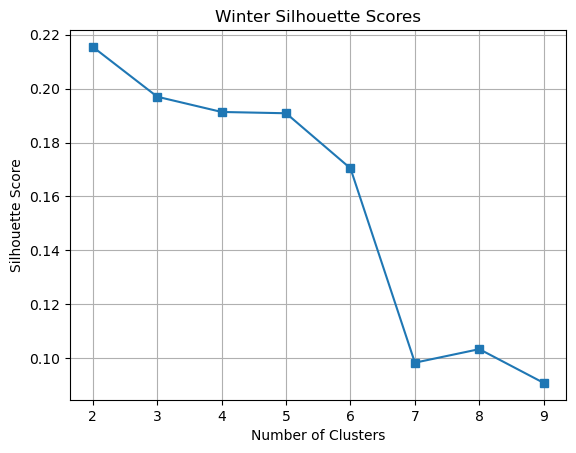

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Chosen k for Winter: 2


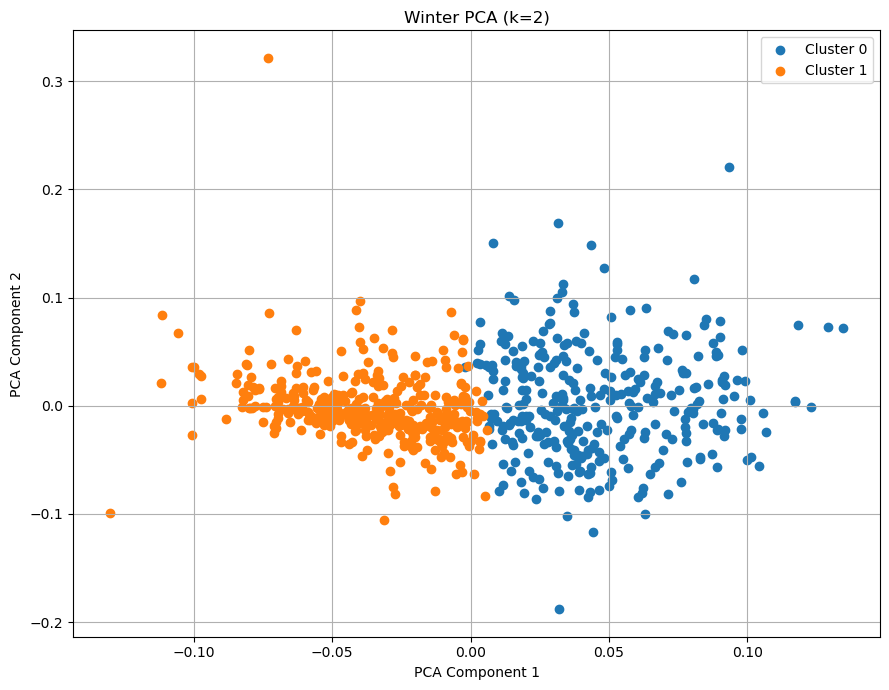

[SAVE] winter_clustered_profiles.csv

Winter — number of houses per cluster:
Cluster
0    324
1    407
Name: count, dtype: int64


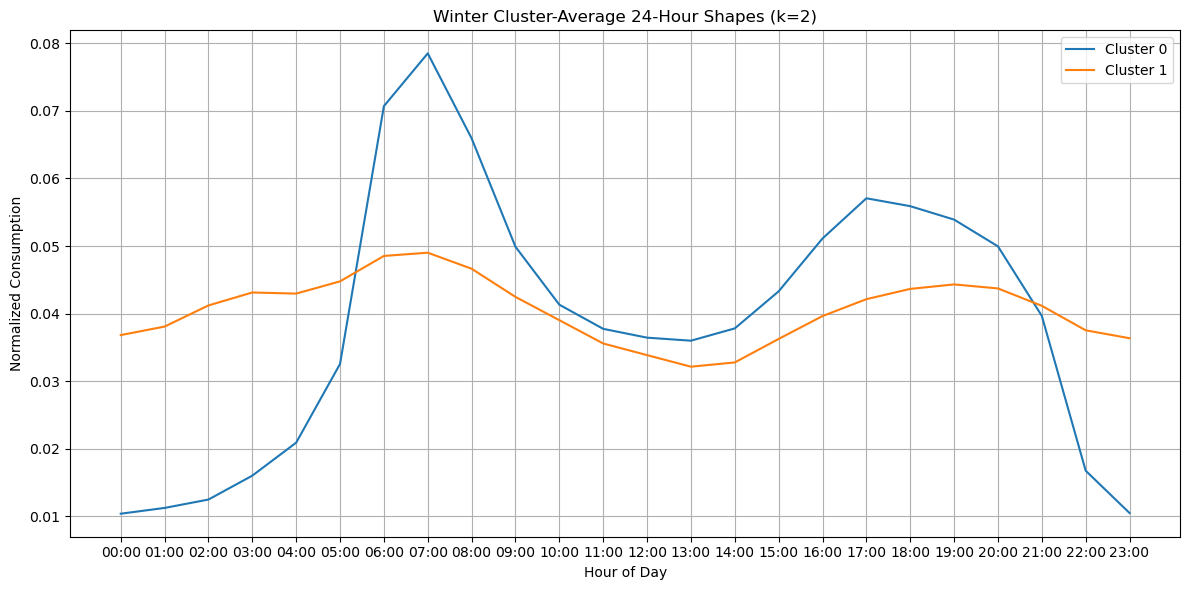

In [26]:
# ======== PIPELINE ========
print("Building SUMMER profiles (Apr–Oct) ...")
summer_df = process_all_files_by_season(DATA_DIR, SUMMER_MONTHS)
print(f"Summer valid houses: {len(summer_df)}")

print("\nBuilding WINTER profiles (Nov–Mar) ...")
winter_df = process_all_files_by_season(DATA_DIR, WINTER_MONTHS)
print(f"Winter valid houses: {len(winter_df)}")

# Impute (should rarely be needed for 24h, but safe)
imputer = SimpleImputer(strategy='mean')

# ---- SUMMER CLUSTERING ----
if not summer_df.empty:
    Xs = imputer.fit_transform(summer_df[[f'Hour_{i:02d}' for i in range(24)]])
    lab_s, k_s, km_s, _, _ = choose_k_and_cluster(Xs, K_RANGE, RANDOM_STATE, title_prefix="Summer ")
    print(f"Chosen k for Summer: {k_s}")
    # PCA + shapes
    plot_pca(Xs, lab_s, f"Summer PCA (k={k_s})")
    summer_labeled = finalize_and_export('summer', summer_df, lab_s, km_s)
    plot_cluster_shapes(summer_labeled, f"Summer Cluster-Average 24-Hour Shapes (k={k_s})")
else:
    print("[INFO] No Summer data to cluster.")

# ---- WINTER CLUSTERING ----
if not winter_df.empty:
    Xw = imputer.fit_transform(winter_df[[f'Hour_{i:02d}' for i in range(24)]])
    lab_w, k_w, km_w, _, _ = choose_k_and_cluster(Xw, K_RANGE, RANDOM_STATE, title_prefix="Winter ")
    print(f"Chosen k for Winter: {k_w}")
    # PCA + shapes
    plot_pca(Xw, lab_w, f"Winter PCA (k={k_w})")
    winter_labeled = finalize_and_export('winter', winter_df, lab_w, km_w)
    plot_cluster_shapes(winter_labeled, f"Winter Cluster-Average 24-Hour Shapes (k={k_w})")
else:
    print("[INFO] No Winter data to cluster.")

In [ ]:
if not summer_df.empty:
    Xs = imputer.fit_transform(summer_df[[f'Hour_{i:02d}' for i in range(24)]])
    lab_s, k_s, km_s, _, _ = choose_k_and_cluster(Xs, K_RANGE, RANDOM_STATE, title_prefix="Summer ")
    print(f"Chosen k for Summer: {k_s}")
    # PCA + shapes
    plot_pca(Xs, lab_s, f"Summer PCA (k={k_s})")
    summer_labeled = finalize_and_export('summer', summer_df, lab_s, km_s)
    plot_cluster_shapes(summer_labeled, f"Summer Cluster-Average 24-Hour Shapes (k={k_s})")
else:
    print("[INFO] No Summer data to cluster.")

# ---- WINTER CLUSTERING ----
if not winter_df.empty:
    Xw = imputer.fit_transform(winter_df[[f'Hour_{i:02d}' for i in range(24)]])
    lab_w, k_w, km_w, _, _ = choose_k_and_cluster(Xw, K_RANGE, RANDOM_STATE, title_prefix="Winter ")
    print(f"Chosen k for Winter: {k_w}")
    # PCA + shapes
    plot_pca(Xw, lab_w, f"Winter PCA (k={k_w})")
    winter_labeled = finalize_and_export('winter', winter_df, lab_w, km_w)
    plot_cluster_shapes(winter_labeled, f"Winter Cluster-Average 24-Hour Shapes (k={k_w})")
else:
    print("[INFO] No Winter data to cluster.")

[WARN] No 'Timestamp' in Property_ID=EOH1880.csv
[WARN] No 'Timestamp' in Property_ID=EOH0345.csv


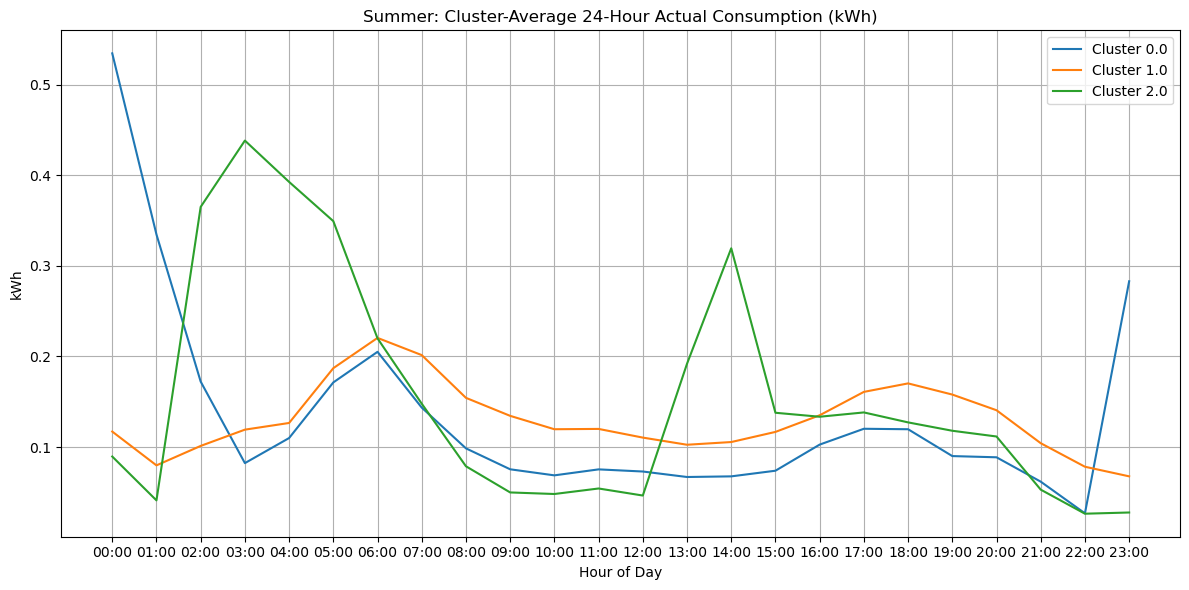

[SAVE] summer_house_actual_with_clusters.csv
[SAVE] summer_cluster_mean_actual_kwh.csv


In [27]:
# Build raw (kWh) 24h profiles for SUMMER
summer_actual = process_all_files_actual_by_season(DATA_DIR, SUMMER_MONTHS)
summer_actual['House'] = summer_actual['House'].str.extract(r'Property_ID=(.*)\.csv').fillna(summer_actual['House'])

# Map cluster labels from summer_labeled (which already has House + Cluster)
summer_actual_labeled = summer_actual.merge(
    summer_labeled[['House', 'Cluster']],
    on='House', how='left'
)

# Compute cluster mean actual profiles (kWh)
hours = [f'Hour_{i:02d}' for i in range(24)]
summer_cluster_mean_kwh = summer_actual_labeled.groupby('Cluster')[hours].median().sort_index()

# Plot
plt.figure(figsize=(12,6))
for c in summer_cluster_mean_kwh.index:
    plt.plot(range(24), summer_cluster_mean_kwh.loc[c].values, label=f'Cluster {c}')
plt.title('Summer: Cluster-Average 24-Hour Actual Consumption (kWh)')
plt.xlabel('Hour of Day')
plt.ylabel('kWh')
plt.xticks(ticks=range(24), labels=[f"{h:02d}:00" for h in range(24)])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Export
summer_actual_labeled.to_csv('summer_house_actual_with_clusters.csv', index=False)
summer_cluster_mean_kwh.to_csv('summer_cluster_mean_actual_kwh.csv')
print("[SAVE] summer_house_actual_with_clusters.csv")
print("[SAVE] summer_cluster_mean_actual_kwh.csv")

[WARN] No 'Timestamp' in Property_ID=EOH1880.csv
[WARN] No 'Timestamp' in Property_ID=EOH0345.csv


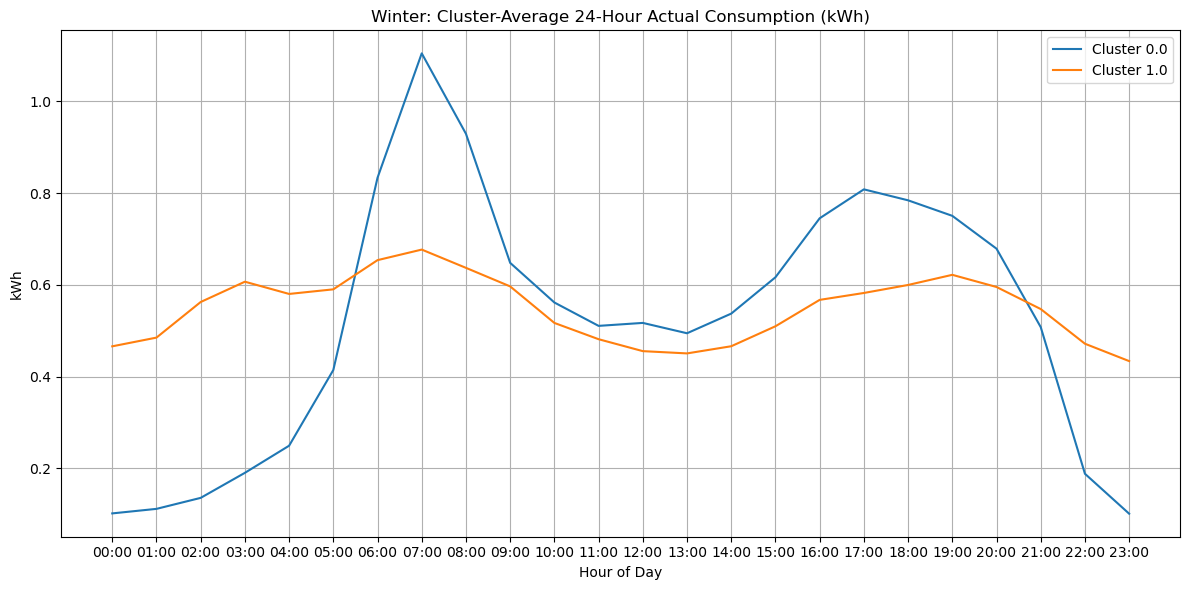

[SAVE] winter_house_actual_with_clusters.csv
[SAVE] winter_cluster_mean_actual_kwh.csv


In [28]:
# Build raw (kWh) 24h profiles for WINTER
winter_actual = process_all_files_actual_by_season(DATA_DIR, WINTER_MONTHS)
winter_actual['House'] = winter_actual['House'].str.extract(r'Property_ID=(.*)\.csv').fillna(winter_actual['House'])

# Map cluster labels from winter_labeled
winter_actual_labeled = winter_actual.merge(
    winter_labeled[['House', 'Cluster']],
    on='House', how='left'
)

# Compute cluster mean actual profiles (kWh)
hours = [f'Hour_{i:02d}' for i in range(24)]
winter_cluster_mean_kwh = winter_actual_labeled.groupby('Cluster')[hours].median().sort_index()

# Plot
plt.figure(figsize=(12,6))
for c in winter_cluster_mean_kwh.index:
    plt.plot(range(24), winter_cluster_mean_kwh.loc[c].values, label=f'Cluster {c}')
plt.title('Winter: Cluster-Average 24-Hour Actual Consumption (kWh)')
plt.xlabel('Hour of Day')
plt.ylabel('kWh')
plt.xticks(ticks=range(24), labels=[f"{h:02d}:00" for h in range(24)])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Export
winter_actual_labeled.to_csv('winter_house_actual_with_clusters.csv', index=False)
winter_cluster_mean_kwh.to_csv('winter_cluster_mean_actual_kwh.csv')
print("[SAVE] winter_house_actual_with_clusters.csv")
print("[SAVE] winter_cluster_mean_actual_kwh.csv")

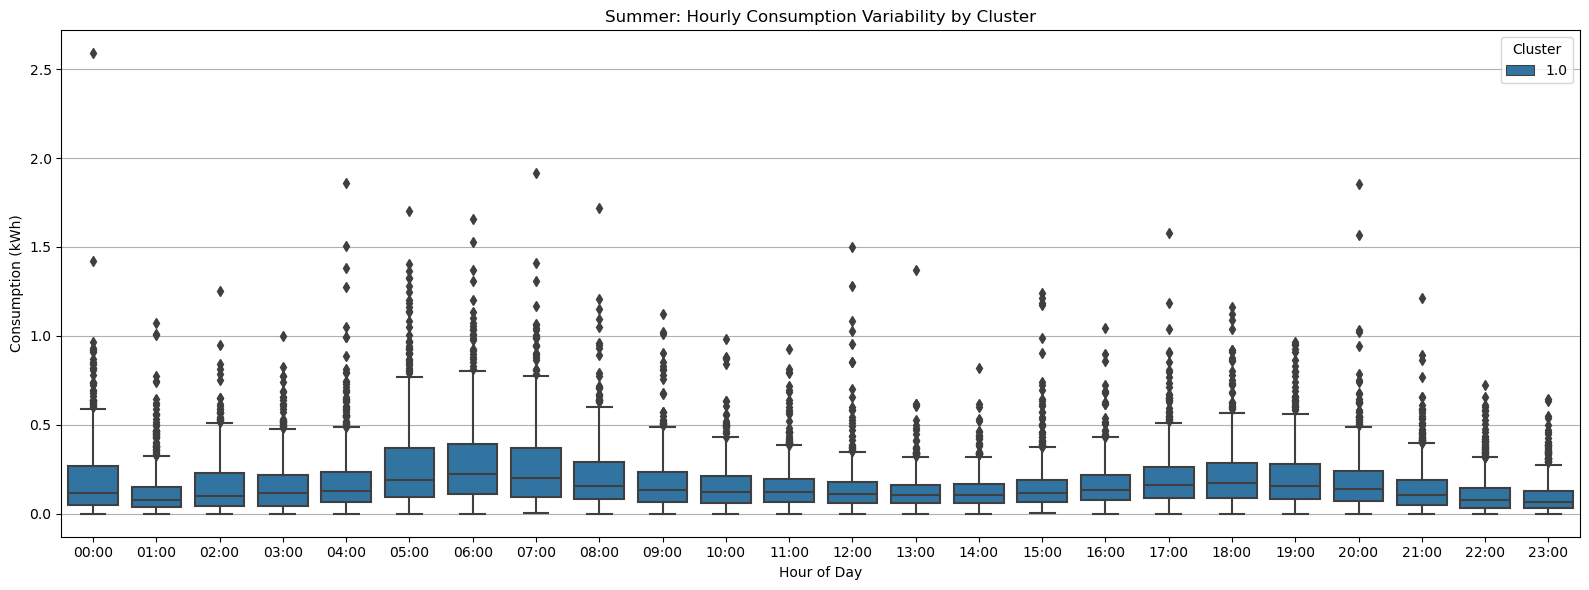

In [36]:
clusters_to_remove = [0, 2]
summer_melted = summer_actual_labeled.melt(
    id_vars=['House', 'Cluster'],
    value_vars=[f'Hour_{i:02d}' for i in range(24)],
    var_name='Hour', value_name='kWh'
)

# Convert Hour_XX to integer hours for plotting
summer_melted['Hour'] = summer_melted['Hour'].str.extract(r'(\d+)').astype(int)
summer_filtered = summer_melted[~summer_melted['Cluster'].isin(clusters_to_remove)]

# Plot boxplots for each cluster
plt.figure(figsize=(16, 6))
sns.boxplot(data=summer_filtered, x='Hour', y='kWh', hue='Cluster')
plt.title('Summer: Hourly Consumption Variability by Cluster')
plt.xlabel('Hour of Day')
plt.ylabel('Consumption (kWh)')
plt.xticks(ticks=range(24), labels=[f"{h:02d}:00" for h in range(24)])
plt.legend(title='Cluster')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

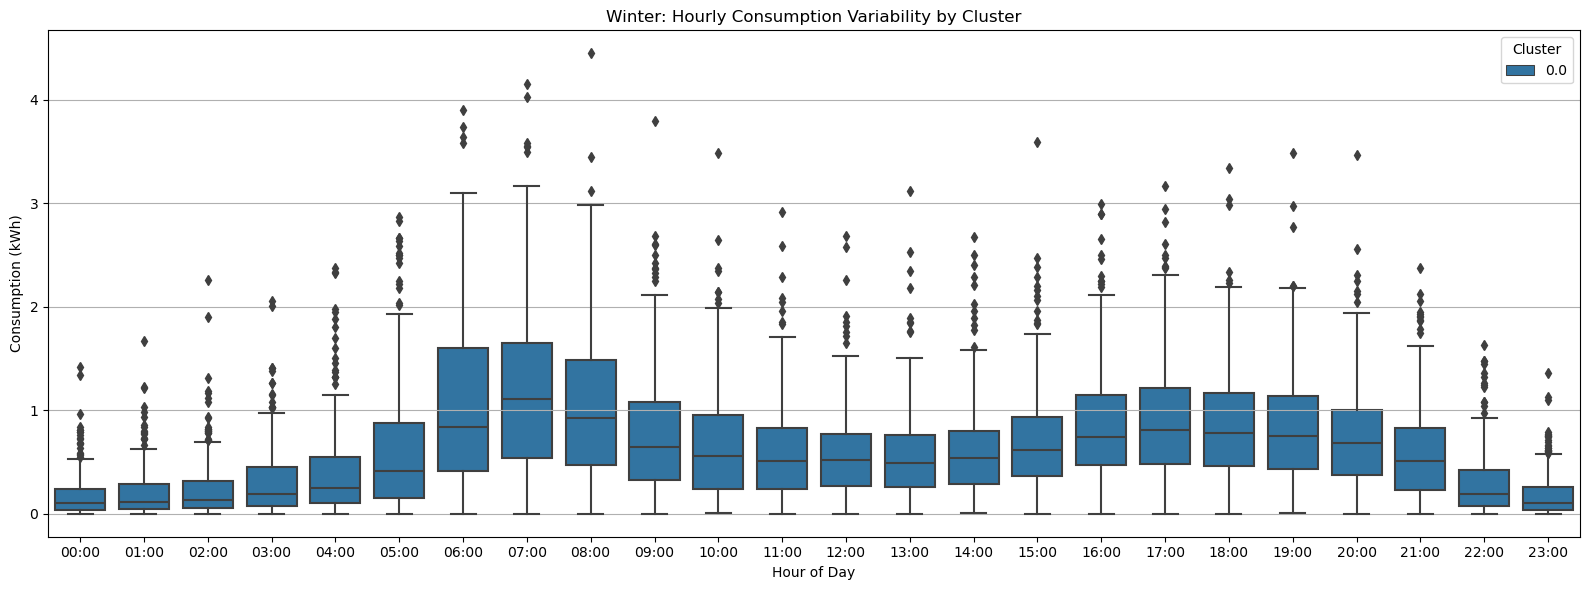

In [35]:
clusters_to_remove = [1]

winter_melted = winter_actual_labeled.melt(
    id_vars=['House', 'Cluster'],
    value_vars=[f'Hour_{i:02d}' for i in range(24)],
    var_name='Hour', value_name='kWh'
)

# Convert Hour_XX to integer hours
winter_melted['Hour'] = winter_melted['Hour'].str.extract(r'(\d+)').astype(int)
winter_filtred = winter_melted[~winter_melted['Cluster'].isin(clusters_to_remove)]

# Plot boxplots for each cluster
plt.figure(figsize=(16, 6))
sns.boxplot(data=winter_filtred, x='Hour', y='kWh', hue='Cluster')
plt.title('Winter: Hourly Consumption Variability by Cluster')
plt.xlabel('Hour of Day')
plt.ylabel('Consumption (kWh)')
plt.xticks(ticks=range(24), labels=[f"{h:02d}:00" for h in range(24)])
plt.legend(title='Cluster')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()